In [5]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [6]:
from sm_funcs import get_spectral_type
import sm_funcs


In [7]:
keplerstellar = pd.read_csv('../data/kepler_stellar17.csv.gz', delimiter='|')
allquarters = keplerstellar.st_quarters == 11111111111111111
isGoodData = np.isfinite(keplerstellar.mass) & (keplerstellar.st_radius < 3.5)

In [8]:
# we want interpolate a relationship between temperate and absolute magnitude

mamajek = pd.read_table('../data/EEM_dwarf_UBVIJHK_colors_Teff.txt', 
                        skiprows=20, delim_whitespace=True, skipfooter=440,
                        engine='python', na_values=['...','....','.....'])
mamajek.columns = [c.replace('-', '_') for c in mamajek.columns]


mamajek.loc[:,'Mr'] =   - mamajek.loc[:,'Mv'] - mamajek.loc[:,'V_Rc']



In [9]:
# from Raghavan et al. 2010

# orbital period distribution
logPeriod = np.random.normal(5.03,2.28, size=keplerstellar.shape[0])

#for OBAFMKMLT
binaryProbability = {'O': 0.75, 
                      'B': 0.70, 
                      'A': 0.70, 
                      'F': 0.50,
                      'G': 0.41,
                      'K': 0.41,
                      'M': 0.35,
                      'L': 0.20,
                      'T': 0.20,
                      }

# mass ratio can be approximated by a uniform
# but it may be better estimated by distribution that increases toward higher number
# so I'll use uniform in (e - e^(x)) / (e - 1)
massRatio = (np.e-np.e**(np.random.uniform(size=keplerstellar.shape[0]))) / (np.e-1.0)
mp = keplerstellar.loc[:,'mass'].copy()
compMass = mp * massRatio

# we need to companion mass to be in the stellar range, so > 0.08
while np.any(compMass < 0.08):
    nSmall = np.shape(compMass[compMass < 0.08])[0]
    massRatio[compMass < 0.08] = (np.e-np.e**(np.random.uniform(size=nSmall))) / (np.e-1.0)
    compMass[compMass < 0.08] = mp[compMass < 0.08] * massRatio[compMass < 0.08]


In [10]:
# let's make some new columns that we'll need

stype_arr = np.empty(keplerstellar.shape[0], dtype='str')
isBinary_arr = np.empty(keplerstellar.shape[0], dtype='bool')

for idx in tqdm(range(keplerstellar.shape[0])):
    stype = get_spectral_type(keplerstellar['teff'][idx])
    stype_arr[idx] = stype
    isBinary_arr[idx] = binaryProbability[stype]  <  np.random.uniform()




100%|██████████| 200038/200038 [00:06<00:00, 32102.32it/s]


In [11]:
# which star should the planet orbit
# we'll say it's 50/50 unless the companion is an M-dwarf
# let's say that the max mass of an M-dwarf is 0.55 Msun
# and let's say that if it's an M-dwarf, the probability the planet's around a companion is 2.5/0.689

orbitProb = np.where(compMass<=0.55, 1. - (0.689/2.5), 0.5)
orbitProb[~isBinary_arr] = 0.0
orbitsPrimary = np.where(np.random.uniform(size=keplerstellar.shape[0]) > orbitProb, True, False)


In [12]:
# it's a factor of a few hundred times faster to loop and add to the dataframe
keplerstellar.loc[:,'stype'] = stype_arr
keplerstellar.loc[:,'isBinary'] = isBinary_arr
keplerstellar.loc[:,'massRatio'] = massRatio
keplerstellar.loc[:,'period'] = np.e**logPeriod
keplerstellar.loc[:,'compMass'] = compMass
keplerstellar.loc[:,'orbitsPrimary'] = orbitsPrimary
keplerstellar.loc[:,'hostMass'] = np.where(orbitsPrimary, 
                                     keplerstellar.mass, compMass)


In [13]:
# now let's make an array that excludes things we don't want
q = keplerstellar.loc[allquarters & isGoodData,:]

In [14]:
#some parameters we will need later

# let's make them all transit for now
# q.loc[:,'cosi'] = pd.Series(np.random.random(size=q.shape[0]),name='cosi')

q.loc[:,'noise_level'] = sm_funcs.kepler_noise_6h(q.loc[:,'kepmag']) * np.sqrt(6)


/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
# add planets
# first draw planets

planets = sm_funcs.flat_select(q.shape[0])

# then assign either a planet from Fressin or Dressing
[planetRadius, planetPeriod] = planets



(array([ 10146.,  10326.,  10292.,  10375.,  10214.,  10280.,  10387.,
         10333.,  10264.,  10380.]),
 array([ 0.01012184,  1.00910808,  2.00809431,  3.00708055,  4.00606678,
         5.00505302,  6.00403925,  7.00302548,  8.00201172,  9.00099795,
         9.99998419]),
 <a list of 10 Patch objects>)

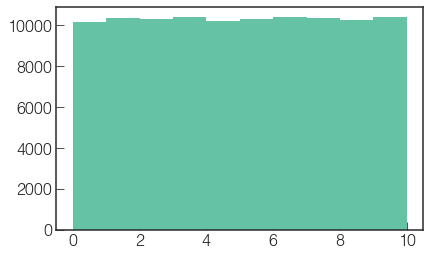

In [19]:
m = np.isfinite(mamajek.loc[:,'Mr']) & np.isfinite(mamajek.loc[:,'Msun'])

Mr_primary = np.interp(q.loc[:,'mass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)
Mr_companion = np.interp(q.loc[:,'compMass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)

# we need to get a radius for the companion
mamajekRadius = np.sqrt(10**mamajek.loc[:,'logL'][m] / (mamajek.loc[:,'Teff'][m]**4 / 5778.**4))
compRadius = np.interp(q.loc[:,'compMass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajekRadius[::-1], np.nan, np.nan)
q.loc[:,'compRadius'] = compRadius
q.loc[:,'hostRadius'] = np.where(q.loc[:,'orbitsPrimary'], q.loc[:,'st_radius'], q.loc[:,'compRadius'])

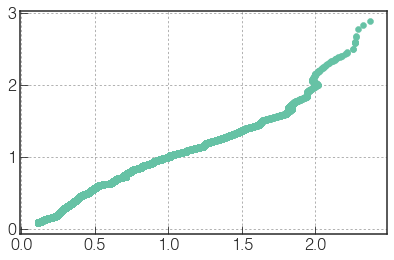

In [20]:
plt.scatter(q.loc[:,'compRadius'], q.loc[:,'compMass'])
plt.grid()

In [21]:
q.loc[:,'planetRadius'] = planetRadius
q.loc[:,'planetPeriod'] = planetPeriod
q.loc[:,'rprs'] = sm_funcs.get_rprs(planetRadius, q.loc[:,'hostRadius'])
q.loc[:, 'ars'] = sm_funcs.per2ars(planetPeriod, q.loc[:,'hostMass'], 
                                   q.loc[:,'hostRadius'])

# need a fudge here to stop a/r* < 1
q.loc[:, 'ars'] = np.where(q.loc[:, 'ars'] < 1.0, 1.01, q.loc[:, 'ars'])

q.loc[:, 'duration'] = sm_funcs.get_duration(planetPeriod, q.loc[:,'ars'], rprs=q.loc[:,'rprs'])

sm_funcs.py:481: RuntimeWarning: invalid value encountered in arcsin
  duration = part1 * np.arcsin(part2 * part3 / part4)


In [22]:
q.loc[:,'duration_correction'] = np.sqrt(q.loc[:,'duration'] * 24.) # correction for CDPP because transit dur != 1 hour
q.loc[:,'transit_depth_undiluted']  = sm_funcs.get_transit_depth(q.loc[:,'planetRadius'], 
                                                                 q.loc[:,'hostRadius']) * 1.E-6


In [23]:
# we need to go from undiluted transit depth to diluted transit depth
# so we have deltaF / F1 and we want deltaF/(F1+F2)

# we should do this calculation in magnitude
# so take the kepmag and estimate the kepmag for a companion

q.loc[:,'transit_depth_diluted'] = 0.
q.ix[~q.isBinary, 'transit_depth_diluted']  = q.loc[:,'transit_depth_undiluted' ]
q.ix[q.isBinary & q.orbitsPrimary, 'transit_depth_diluted'] = q.loc[:,'transit_depth_undiluted'] / (
    1+10**((Mr_primary - Mr_companion) / -2.5))
q.ix[q.isBinary & ~q.orbitsPrimary, 'transit_depth_diluted'] =  q.transit_depth_undiluted / (
    1+10**((Mr_companion - Mr_primary) / -2.5))


# should be every star
assert( (q.ix[~q.isBinary, 'transit_depth_diluted'].shape[0] + 
 q.ix[q.isBinary & q.orbitsPrimary, 'transit_depth_diluted'].shape[0] + 
 q.ix[q.isBinary & ~q.orbitsPrimary, 'transit_depth_diluted'].shape[0]) == q['transit_depth_diluted'].shape[0])

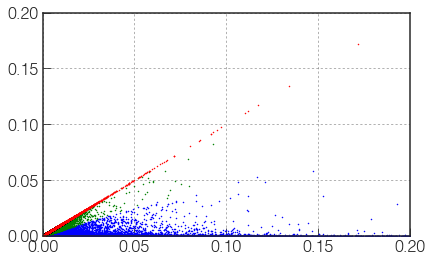

In [24]:

# binary, orbits companion
plt.scatter(q.transit_depth_undiluted[q.isBinary & ~q.orbitsPrimary] , 
            q.transit_depth_diluted[q.isBinary & ~q.orbitsPrimary], 
            c='blue', s=1)

# binary, orbits primary
plt.scatter(q.transit_depth_undiluted[q.isBinary & q.orbitsPrimary] , 
            q.transit_depth_diluted[q.isBinary & q.orbitsPrimary], 
            c='green', s=1)
# single star
plt.scatter(q.transit_depth_undiluted[~q.isBinary], 
            q.transit_depth_diluted[~q.isBinary], 
            c='red', s=1)

plt.xlim(0,0.2)
plt.ylim(0,0.2)
plt.grid()

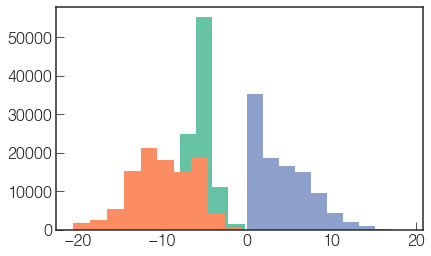

In [25]:
z = plt.hist(Mr_primary, )
z = plt.hist(Mr_companion, )
z = plt.hist(Mr_primary - Mr_companion, )

In [26]:
# finally, we need to build a detection model
# the detection can be a simple SNR threshold, let's pick 8 sigma
# so the probability of detection is if
# SNR > 8
# SNR = sqrt(ntransits) * duration_correction * transit_depth / noise
keplerduration = 4.0 * 365.
ntransits = np.around(keplerduration / q.planetPeriod )
sigma_threshold = 8.0

needed_for_detection_diluted = (q.transit_depth_diluted * 1.E6 * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_diluted = q.noise_level < needed_for_detection_diluted

needed_for_detection_undiluted = (q.transit_depth_undiluted * 1.E6 * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_undiluted = q.noise_level < needed_for_detection_undiluted

In [27]:
print(np.nonzero(detected_diluted)[0].shape)
print(np.nonzero(detected_undiluted[q.orbitsPrimary])[0].shape)

print(np.nonzero(detected_diluted & ~q.orbitsPrimary)[0].shape)

(72990,)
(59237,)
(14094,)


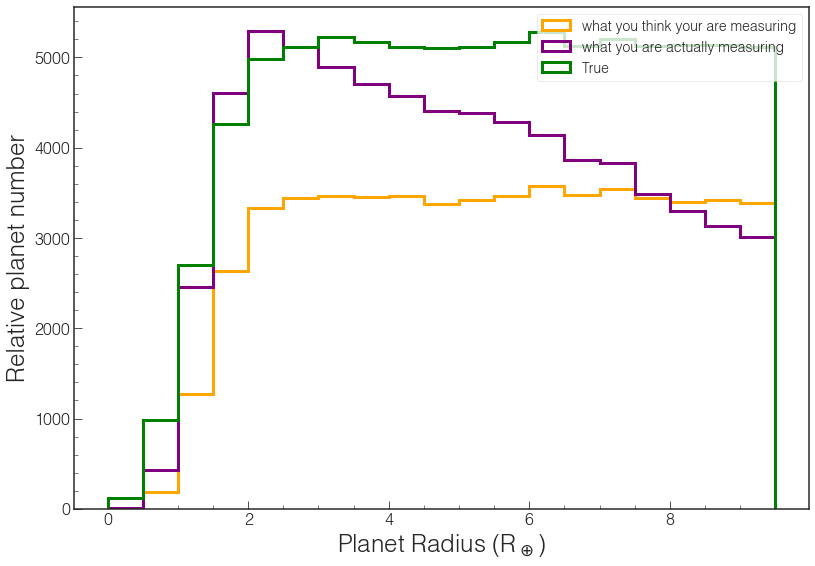

In [28]:


fig = plt.figure(figsize=[12,9])


plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * 
         q.hostRadius[detected_undiluted][q.orbitsPrimary] / 0.009155, 
         bins=np.arange(0,10,0.5),
         histtype='step', lw=3, color='orange',#, normed=True
         label='what you think your are measuring',
        )
plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155, 
         bins=np.arange(0,10,0.5), 
         histtype='step', lw=3, color='purple',#, normed=True
         label='what you are actually measuring',
        )

plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted] * q.hostRadius[detected_undiluted] / 0.009155, 
         bins=np.arange(0,10,0.5), 
         histtype='step', lw=3, color='green',#, normed=True
         label='True',
        )

plt.legend()
plt.xlabel('Planet Radius (R$_\oplus$)')
plt.ylabel('Relative planet number')

plt.minorticks_on()

(array([  191.,  3911.,  6771.,  6919.,  6844.,  6884.,  7057.,  6990.,
         6823.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 1 Patch objects>)

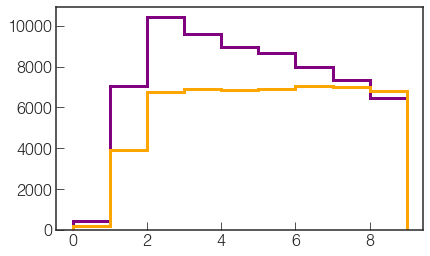

In [29]:
plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155, 
         bins=np.arange(0,10,1), 
         histtype='step', lw=3, color='purple',#, normed=True
         label='including binaries',
        )
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * 
         q.hostRadius[detected_undiluted][q.orbitsPrimary] / 0.009155, 
         bins=np.arange(0,10,1),
         histtype='step', lw=3, color='orange',#, normed=True
         label='no binaries',
        )

(0, 0.5)

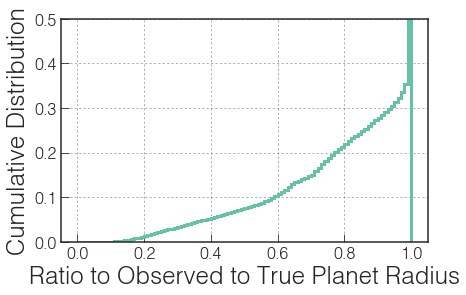

In [30]:
o1 = np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155
o2 = np.sqrt(q.transit_depth_undiluted)[detected_diluted] * q.hostRadius[detected_diluted] / 0.009155

plt.hist((o1/o2), histtype='step',  cumulative=True, bins=np.arange(0,1.01,0.01), normed=True, lw=3)
plt.grid()
plt.xlabel('Ratio to Observed to True Planet Radius')
plt.ylabel('Cumulative Distribution')

plt.ylim(0,0.5)

(array([  6.25640000e+04,   1.94620000e+04,   4.76600000e+03,
          1.96700000e+03,   8.02000000e+02,   3.47000000e+02,
          2.49000000e+02,   1.75000000e+02,   9.90000000e+01,
          4.20000000e+01]),
 array([ 0.00303841,  0.08263359,  0.16222877,  0.24182395,  0.32141914,
         0.40101432,  0.4806095 ,  0.56020468,  0.63979987,  0.71939505,
         0.79899023]),
 <a list of 1 Patch objects>)

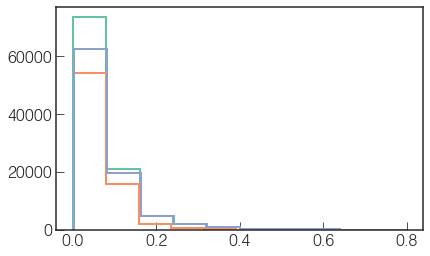

In [32]:
plt.hist(np.sqrt(q.transit_depth_undiluted), histtype='step', lw=2)
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_diluted], histtype='step', lw=2)
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted], histtype='step', lw=2)

(array([   981.,   9028.,  11410.,  10524.,   9604.,   8468.,   7120.,
          5724.,   4595.,   3518.,   1894.,    124.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 1 Patch objects>)

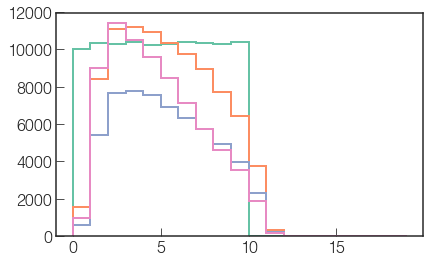

In [34]:
plt.hist(q.planetRadius, bins=np.arange(0,20,1), histtype='step', lw=2)

plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted] * q.hostMass[detected_undiluted] / 0.009155,
        bins=np.arange(0,20,1), histtype='step', lw=2 )

plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * q.hostMass[detected_undiluted][q.orbitsPrimary] / 0.009155,
        bins=np.arange(0,20,1), histtype='step', lw=2 )

plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.mass[detected_diluted] / 0.009155,
        bins=np.arange(0,20,1), histtype='step', lw=2 )

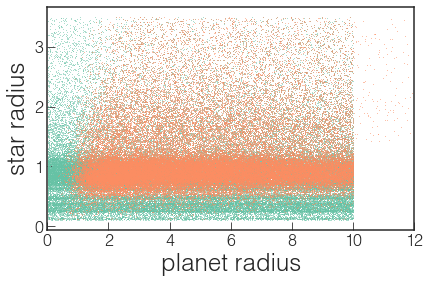

In [41]:
plt.scatter(q.planetRadius, q.hostRadius, s=0.1)
plt.scatter( 
            np.sqrt(q.transit_depth_diluted[detected_diluted]) * 
            q.st_radius[detected_diluted] / 0.009155, 
            q.st_radius[detected_diluted],
            s=0.1)
#plt.ylim(0,4)
plt.xlim(0,12)

plt.xlabel('planet radius')
plt.ylabel('star radius')